# Carga de Datos



In [ ]:
import io
import pandas as pd
from google.colab import files
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Utilizo la base de datos luego de eliminar las columnas cod_prov y nom_prov

In [ ]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving despob_pob_actividad_ocupados_ipc_pib_2023.csv to despob_pob_actividad_ocupados_ipc_pib_2023 (1).csv
User uploaded file "despob_pob_actividad_ocupados_ipc_pib_2023 (1).csv" with length 14593 bytes


In [ ]:
df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), sep=";")

In [ ]:
df.drop(['cod_prov', 'nom_prov'], axis=1, inplace=True)

Asigno el valor 0 a las provincias con porcentaje despoblamiento >= a 50%. Valor 1 a las provincias con despoblamiento >= 30 y < 50%. Por ultimo se asigna el valor 2 a las provincias con despoblamiento < 30%

In [ ]:
df.loc[df["porcen_desp"] >= 50, "porcen_desp"] = 0
df.loc[df["porcen_desp"] >= 30, "porcen_desp"] = 1
df.loc[df["porcen_desp"] >= 2, "porcen_desp"] = 2

In [ ]:
df['porcen_desp'].unique()

array([0, 1, 2])

Posteriormente seleccionamos las variables con las que trabajar.

Es muy importante seleccionar las características cuando se va a resolver un problema mediante kNN ya que muchas variables pueden distorsionar el resultado del algoritmo que está basado en la distancia.

Para realizar esta selección vamos a utilizar la correlación entre cada una de las características y la variable a predecir.



In [ ]:
df.keys()

Index(['porcen_desp', 'pob_tot', 'pob_hom', 'pob_muj', 'asexos_tactividad',
       'asexos_templeo', 'asexos_tparo', 'hombres_tactividad',
       'hombres_templeo', 'hombres_tparo', 'mujeres_tactividad',
       'mujeres_templeo', 'mujeres_tparo', 'ocupados_agricultura',
       'ocupados_construccion', 'ocupados_industria', 'ocupados_servicios',
       'ipc_alim', 'ipc_bebi', 'ipc_vest', 'ipc_vivi', 'ipc_hoga', 'ipc_sani',
       'ipc_trans', 'ipc_comu', 'ipc_ocio', 'ipc_ense', 'ipc_resta',
       'ipc_otros', 'pib_prec', 'pib_agri', 'pib_indu', 'pib_ind_manu',
       'pib_constr', 'pib_comer', 'pib_act_fin', 'pib_admin', 'pib_valor_brut',
       'pib_imp_netos'],
      dtype='object')

<Axes: >

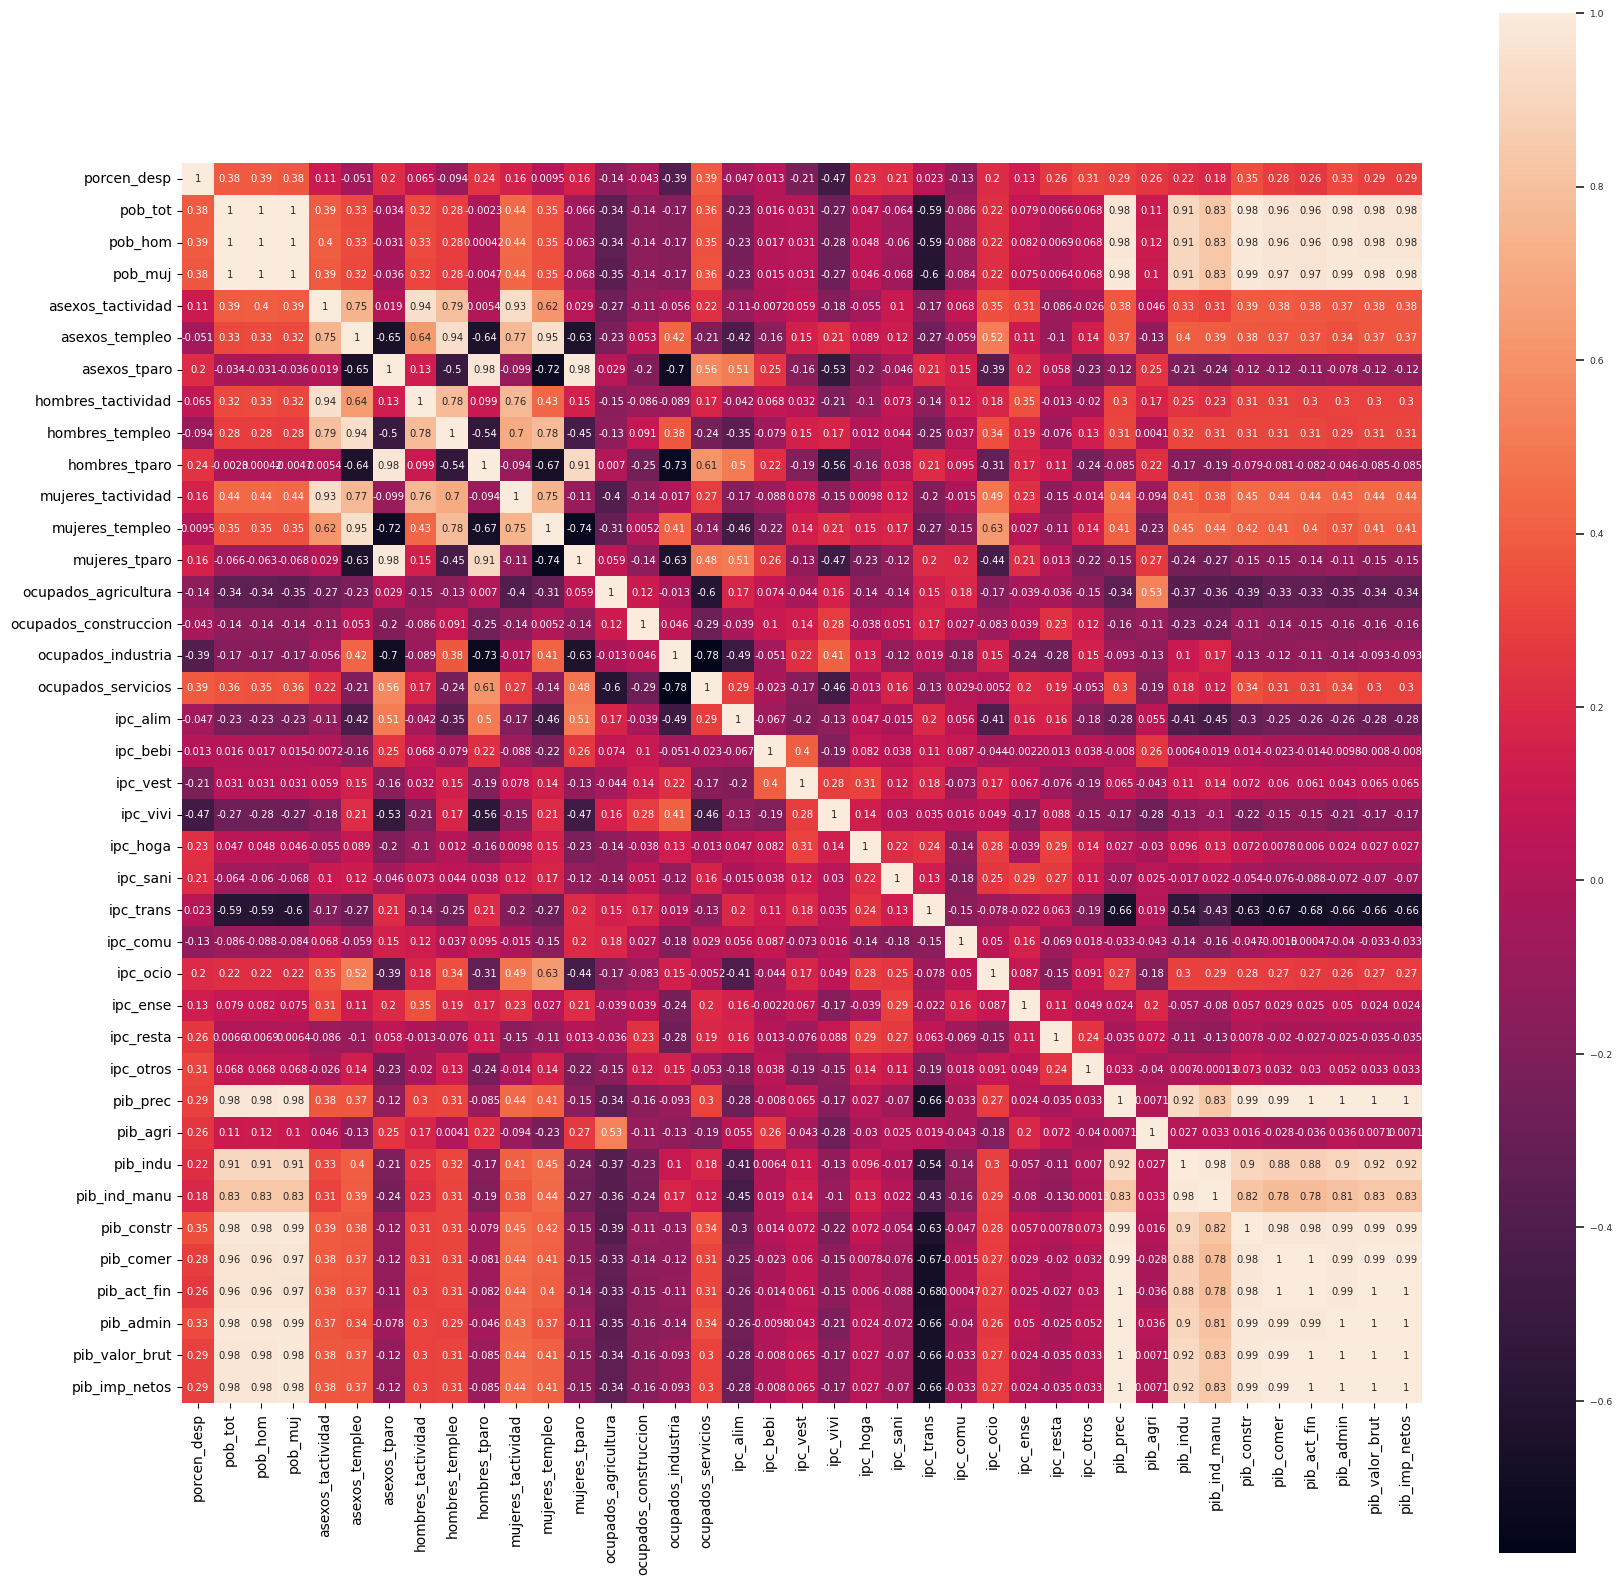

In [ ]:
plt.subplots(figsize=(20, 20))
sns.set(font_scale=0.6)
sns.heatmap(df.corr(), square=True, annot=True)

Eligo trabajar con las variables hombres_tparo, ocupados_servicios, ipc_vivi, pib_constr y pib_valor_brut

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df[['hombres_tparo','ocupados_servicios','ipc_vivi', 'pib_constr', 'pib_valor_brut', 'porcen_desp']], test_size=0.33)
train.reset_index(inplace = True)
test.reset_index(inplace = True)

#1. Parametrización



Max Value uniform : 0.7285714285714285 (9)
Max Value distance : 0.6571428571428571 (3)


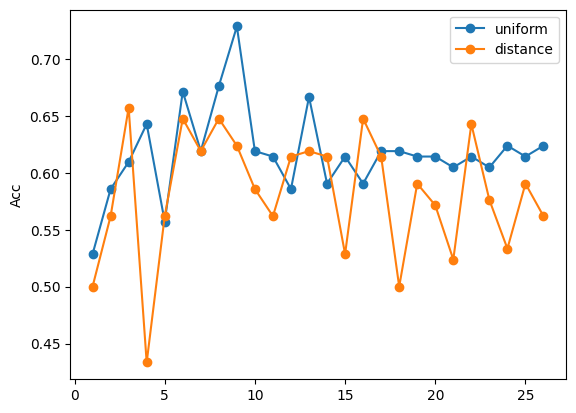

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

cv = KFold(n_splits = 5, shuffle = True)
for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,27):
       fold_accuracy = []
       knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
       for train_fold, test_fold in cv.split(train):
          # División train test aleatoria
          f_train = train.loc[train_fold]
          f_test = train.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(['porcen_desp'], axis=1),
                               y = f_train['porcen_desp'])
          y_pred = knn.predict(X = f_test.drop(['porcen_desp'], axis = 1))
          # evaluación del modelo
          acc = accuracy_score(f_test['porcen_desp'], y_pred)
          fold_accuracy.append(acc)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))

   plt.plot(range(1,len(total_scores)+1), total_scores,
             marker='o', label=weights)
   print ('Max Value ' +  weights + " : " +  str(max(total_scores)) +" (" + str(np.argmax(total_scores) + 1) + ")")
   plt.ylabel('Acc')

plt.legend()
plt.show()

# 2. Construcción y ejecución del modelo



Una vez que hemos identificado la mejor parametrización vamos a pasar a hacer una ejecución del modelo y vamos graficar sus resultados.
Recordamos que al final del paso 1 hemos dividido en entrenamiento/tuneado y test

Posteriormente, vamos a ejecutar el modelo con la mejor parametrización que hayamos obtenido anteriormente

In [ ]:
# constructor
n_neighbors = 9
weights = 'uniform'
knn = neighbors.KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights)
# fit and predict
knn.fit(X = train[['hombres_tparo','ocupados_servicios','ipc_vivi', 'pib_constr', 'pib_valor_brut']], y = train['porcen_desp'])
y_pred = knn.predict(X = test[['hombres_tparo','ocupados_servicios','ipc_vivi', 'pib_constr', 'pib_valor_brut']])
acc = accuracy_score(test['porcen_desp'], y_pred)
print ('Acc', acc)

Acc 0.6666666666666666


Y finalmente visualizamos la Matriz de Confusión

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize,
                          title,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

[[11  0  2]
 [ 1  0  3]
 [ 0  0  1]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

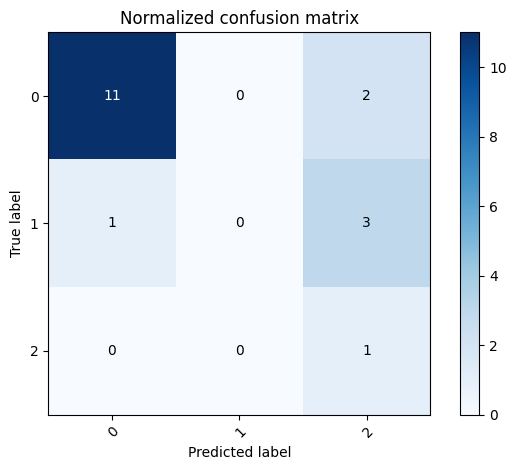

In [ ]:
plot_confusion_matrix(test['porcen_desp'], y_pred, classes=df['porcen_desp'].unique() , normalize=False,
                      title='Confusion matrix')

# Clasificacion con dos variables

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[['ipc_vivi','ocupados_servicios', 'porcen_desp']], test_size=0.33)
train.reset_index(inplace = True)
test.reset_index(inplace = True)

Max Value uniform : 0.7428571428571429 (2)
Max Value distance : 0.761904761904762 (5)


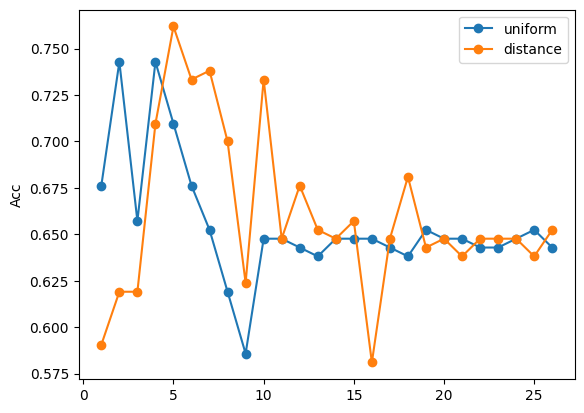

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

cv = KFold(n_splits = 5, shuffle = True)
for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,27):
       fold_accuracy = []
       knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
       for train_fold, test_fold in cv.split(train):
          # División train test aleatoria
          f_train = train.loc[train_fold]
          f_test = train.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(['porcen_desp'], axis=1),
                               y = f_train['porcen_desp'])
          y_pred = knn.predict(X = f_test.drop(['porcen_desp'], axis = 1))
          # evaluación del modelo
          acc = accuracy_score(f_test['porcen_desp'], y_pred)
          fold_accuracy.append(acc)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))

   plt.plot(range(1,len(total_scores)+1), total_scores,
             marker='o', label=weights)
   print ('Max Value ' +  weights + " : " +  str(max(total_scores)) +" (" + str(np.argmax(total_scores) + 1) + ")")
   plt.ylabel('Acc')

plt.legend()
plt.show()

In [ ]:
# constructor
n_neighbors = 5
weights = 'distance'
knn = neighbors.KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights)
# fit and predict
knn.fit(X = train[['ipc_vivi','ocupados_servicios']], y = train['porcen_desp'])
y_pred = knn.predict(X = test[['ipc_vivi','ocupados_servicios']])
acc = accuracy_score(test['porcen_desp'], y_pred)
print ('Acc', acc)

Acc 0.7222222222222222


Graficamos la solución mediante los diagramas de Voronoi

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
h = .05  # step size in the mesh

X = train[['ipc_vivi','ocupados_servicios']].values
y = train['porcen_desp'].values

In [ ]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

In [ ]:
batch_size = 32

In [ ]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                       np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


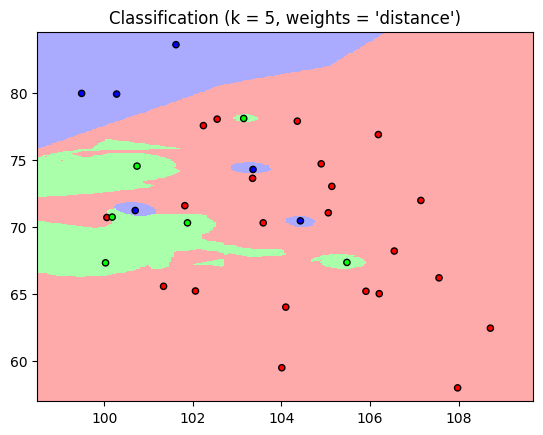

In [ ]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
             edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()

Matriz de confusion

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [ ]:
cm = confusion_matrix(test['porcen_desp'], y_pred, labels=df['porcen_desp'].unique())
cm

array([[9, 1, 2],
       [0, 2, 2],
       [0, 0, 2]])

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

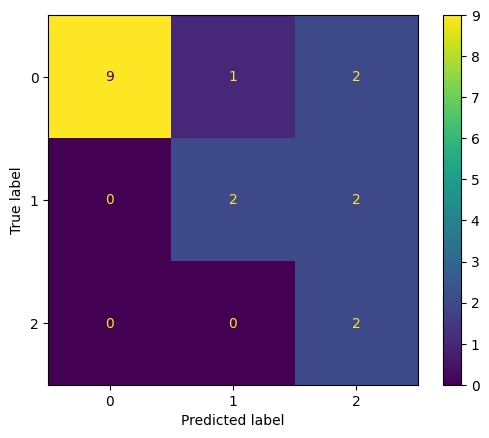

In [ ]:
cm = confusion_matrix(test['porcen_desp'], y_pred, labels=df['porcen_desp'].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df['porcen_desp'].unique())
disp.plot()
plt.show()

In [ ]:
y_pred

array([0, 2, 0, 2, 0, 0, 2, 0, 0, 1, 2, 0, 0, 2, 1, 2, 1, 0])